In [1]:
#! wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# tar -zxvf cifar-10-python.tar.gz

In [1]:
from __future__ import division

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torch import optim
import torch.optim.lr_scheduler as lr_scheduler

from torchvision import models, transforms

import pickle
import numpy as np
import matplotlib.pyplot as plt # plt 用于显示图片
import time
import copy


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [3]:
def show(np_image, title = None):
    # np_image是numpy矩阵类型，形状为(3, 32, 32)
    np_image = np_image.transpose((1, 2, 0))
    plt.imshow(np_image)
    if title is not None:
        plt.title(title)

In [7]:
with open('data/cifar-10-batches-py/test_batch', 'rb') as fo:
    testData = pickle.load(fo, encoding='bytes')

In [8]:
trainData = {b'batch_label':[], b'labels':[], b'data': np.zeros(shape=(0, 3072), dtype='uint8'), b'filenames':[]}

for i in range(1, 6):
    with open('data/cifar-10-batches-py/data_batch_'+str(i), 'rb') as fo:
        data_batch = pickle.load(fo, encoding='bytes')
        trainData[b'labels'] += data_batch[b'labels']
        trainData[b'data'] = np.vstack((trainData[b'data'], data_batch[b'data']))
        trainData[b'filenames'] += data_batch[b'filenames']
print(trainData.keys())
print(len(trainData[b'data']))

# 所有类型
index2label = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# 1-10

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
50000


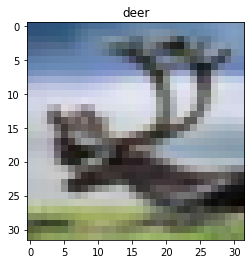

In [10]:
sampleIndex = 40
sampleData = testData[b'data'][sampleIndex]
sampleLabel = testData[b'labels'][sampleIndex]
show(sampleData.reshape((3, 32, 32)), title=index2label[sampleLabel])

In [9]:
class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels):
        # type(data): numpy.arrays shape [batch * 3 * 32 * 32]
        # type(labels): list int
        self.data = data
        self.labels = labels
        
        assert len(self.data) == len(self.labels), "CIFAR10 DATASET data长度与labels长度不一样"
        self.length = len(self.labels)
        
    def __getitem__(self, index):
        return (self.data[index].reshape((3, 32, 32)), self.labels[index])
    
    def __len__(self):
        return self.length

In [10]:
trainDataset = CIFAR10Dataset(trainData[b'data'], trainData[b'labels'])
trainDataloader = DataLoader(trainDataset, batch_size=16, shuffle=False, transformer=transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))

testDataset = CIFAR10Dataset(testData[b'data'], testData[b'labels'])
testDataloader = DataLoader(testDataset, batch_size=16, shuffle=False, transformers=transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))

TypeError: __init__() got an unexpected keyword argument 'transformer'

In [88]:
class CIFAR10Module(nn.Module):
    
    def __init__(self, labelSize=10, bias=False):
        # 3 32 32 -->  16, 32, 32 --> 16, 16, 16 --> 16, 8, 8 --> 4, 8, 8 --> 128
        super(CIFAR10Module, self).__init__()
        
        self.Conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=(1, 1), dilation=1, groups=1, bias=True, padding_mode="zeros")
        self.Relu = nn.ReLU()
        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.Avgpool = nn.AvgPool2d(2)
        self.Conv2 = nn.Conv2d(16, 4, 3, padding=(1, 1))
        self.Sigmoid = nn.Sigmoid()
        self.Tanh = nn.Tanh()
        
        self.linear = nn.Linear(4 * 8 * 8, labelSize)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, input):
        input = input.view((-1, 3, 32, 32))
        output = self.Conv1(input) # (-1, 3, 32, 32) --> (-1, 16, 32, 32)
        
        output = self.Relu(output)
        output = self.Maxpool(output) # 16 x 32 x 32 --> 16 x 16 x 16
        output = self.Sigmoid(output)
        output = self.Avgpool(output) # 16 x 16 x 16 --> 16 x 8 x 8
        output = self.Tanh(output)
        output = self.Conv2(output) # 16 x 8 x 8 --> 4 x 8 x 8
        output = output.view(-1, 4 * 8 * 8)
        output = self.linear(output)
        output = self.softmax(output)
        
        return output
    
cifar10Model = CIFAR10Module()

In [13]:
# 自己的模型
optimizerMe = optim.Adam(params=cifar10Model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
exp_lr_schedulerMe = lr_scheduler.StepLR(optimizerMe, step_size=10, gamma=0.1)
loss_fn = nn.CrossEntropyLoss()

epochs = 10

for epoch in range(epochs):
    for i, (inputs, labels) in enumerate(trainDataloader):
        cifar10Model.train()
        optimizer.zero_grad()
        
        outputs = cifar10Model(inputs.float())
        loss = loss_fn(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 0:
            print(loss.item())

NameError: name 'cifar10Model' is not defined

In [ ]:
dataloaders = {'train':trainDataloader, 'val':testDataloader}
def train_model(model, criterion, optimizer, scheduler, dataloaders, skip = 100, num_epochs=25):
    # 
    import time
    import copy
    
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # 每个epoch都有一个训练和验证的阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            # 迭代数据
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # 零参数梯度
                optimizer.zero_grad()
                
                # 前向
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # 后向仅在训练阶段进行优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if i % skip == 0:
                    print('{} Loss: {:.4f} Acc: {:.4f}={}/{}'.format(phase, loss.item(), torch.sum(preds == labels.data).double()/inputs.size(0), torch.sum(preds == labels.data), inputs.size(0)))

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects.double() / len(dataloaders[phase])
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # 深度复制
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed = time.time() - since
    print('Training compete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# 使用预训练模型

cifar10RES = models.resnet18(pretrained=True)
num_ftrs = cifar10RES.fc.in_features
cifar10RES.fc = nn.Linear(num_ftrs, 10)

num_layers = len(list(cifar10RES.parameters()))
# 冻结模型中除了最后两层外所有层
for iter_layer, p in enumerate(cifar10RES.parameters()):
    if iter_layer < num_layers - 1:
        p.require_grad = False
    else:
        p.require_grad = True
        
optimizerRES = optim.Adam(params=filter(lambda p:p.require_grad, cifar10RES.parameters()), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
exp_lr_schedulerRES = lr_scheduler.StepLR(optimizerRES, step_size=10, gamma=0.1)
loss_fn_RES = nn.CrossEntropyLoss()

train_model(cifar10RES, loss_fn_RES, optimizerRES, exp_lr_schedulerRES, dataloaders, skip=10, num_epochs=25)
# 准确率稳定在16%左右

Epoch 0/24
----------
train Loss: 2.1551 Acc: 0.0625=1/16
train Loss: 2.5954 Acc: 0.0625=1/16
train Loss: 2.6874 Acc: 0.3125=5/16
train Loss: 2.8377 Acc: 0.0000=0/16
train Loss: 2.6365 Acc: 0.1250=2/16
train Loss: 2.5230 Acc: 0.0625=1/16
train Loss: 2.3941 Acc: 0.1250=2/16
train Loss: 2.5498 Acc: 0.0625=1/16
train Loss: 2.6075 Acc: 0.1250=2/16
train Loss: 2.5617 Acc: 0.1250=2/16
train Loss: 2.5052 Acc: 0.0625=1/16
train Loss: 2.5948 Acc: 0.1250=2/16
train Loss: 2.5395 Acc: 0.1250=2/16
train Loss: 2.9053 Acc: 0.0625=1/16
train Loss: 2.3166 Acc: 0.1875=3/16
train Loss: 2.6188 Acc: 0.0625=1/16
train Loss: 2.4401 Acc: 0.0625=1/16
train Loss: 2.6640 Acc: 0.0000=0/16
train Loss: 2.5208 Acc: 0.0000=0/16
train Loss: 2.6140 Acc: 0.0625=1/16
train Loss: 2.5304 Acc: 0.1250=2/16
train Loss: 2.4536 Acc: 0.1250=2/16
train Loss: 2.6741 Acc: 0.1250=2/16
train Loss: 2.3686 Acc: 0.1250=2/16
train Loss: 2.7675 Acc: 0.1250=2/16
train Loss: 2.8303 Acc: 0.0625=1/16
train Loss: 2.4347 Acc: 0.1250=2/16
train 